In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pathlib
import copy

return_series_name = "train/episode_reward"
test_return_series_name = "eval/mean_episode_reward"


# These lines are used to avoid picke errors, credit SO
# https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:


def parse_np_file(file_name, series_name, filter_by_freq):
    data = np.load(file_name)
    outer_dict = data.reshape(1,)[0]
    key = list(outer_dict.keys())[0]
    dicts = outer_dict[key]
    timesteps = [k for k, v in dicts.items() if series_name in v]
    mean_rews = [d[series_name] for d in dicts.values() if series_name in d]
    
    # For whatever reason in some runs the first timestep logs, and in others it doesn't.
    # For consistency, we just always remove it.
    if len(timesteps) > 0 and timesteps[0] == 0:
        timesteps = timesteps[1:]
        mean_rews = mean_rews[1:]
 
    # For whatever reason, a few runs are logging extra  TODO: make sure this isn't deleting any points we care about
    len_before = len(mean_rews)
    if filter_by_freq and len(timesteps) > 0:
        new_timesteps = []
        new_mean_rews = []
        for t, m in zip(timesteps, mean_rews):
            if t % 2000 == 0:
                new_timesteps.append(t)
                new_mean_rews.append(m)
        timesteps = new_timesteps
        mean_rews = new_mean_rews
        if len(mean_rews) < len_before:
            print("reduced extra logging; from ", len_before, " to ", len(mean_rews))
        
    
    print("Lengths found", len(mean_rews), len(timesteps))
    assert len(timesteps) == len(mean_rews), (file_name, len(timesteps), len(mean_rews))
    data = np.stack([timesteps, mean_rews], axis=1)
    all_data = pd.DataFrame(data=data, columns=["Steps","Returns"])
    return all_data
    
    
    
def plot_avg(file_names_dict, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
             load_from_tb=False, base_dir=None, avg_every=None, clip_to=None, series_name=return_series_name,
            include_legend=True, transform_fn=None, pretrain_steps=180000, filter_by_freq=False):
    legend = []

    for file_names in file_names_dict.keys():
        print(file_names)
        runs = []
        steps_list = []
        max_steps = 0
        # Load all the files from numpy arrays
        run_list, alternating = file_names_dict[file_names]
        for seed in run_list:
            full_file_name = os.path.join(base_dir, seed)
            out = parse_np_file(full_file_name, series_name, filter_by_freq)
            csv = pd.DataFrame(data=out['Returns'].values, columns=['Returns'])
            steps = out['Steps'].values.astype(int)
            if avg_every:
                csv = csv.ewm(span=avg_every).mean()
            
            runs.append(csv)
            steps_list.append(steps)
            
        if len(runs) > 0:
            legend.append(file_names)
            
            
            # We're going to use the longest 'steps' array as our x-axis.  First, check that the steps match
            steps_set_list = [set(x) for x in steps_list]
            s1 = steps_set_list[0]
            for s in steps_set_list:
                s1 = s1.union(s)
            union = np.array(sorted(list(s1)))
            
            steps_list_new = []
            runs_new = []
            for s_l, r in zip(steps_list, runs):
                r = r.to_numpy()[:, 0]
                r_new = []
                r_index = 0
                for step in union:
                    if step in s_l:
                        r_new.append(r[r_index])
                        r_index += 1
                    else:
                        r_new.append(np.nan)
                r_new = np.array(r_new)
                # Interpolate between values to remove the nan's
                assert len(r_new) == len(union)
                r_new = pd.DataFrame(data=r_new, index=union)
                r_new = r_new.interpolate(method='index').to_numpy()[:, 0]
                        
                runs_new.append(np.array(r_new))
            
            longest_step = union
            padded_runs = runs_new
  
            # Find the mean and std
            padded_runs = np.stack(padded_runs)
            if transform_fn is not None:
                padded_runs = transform_fn(padded_runs)
            mean_arr = np.nanmean(padded_runs, axis=0)
            std_arr = np.nanstd(padded_runs, axis=0)
 
            # Re-index alternating runs if necessary
            if alternating:
                longest_step, (mean_arr, std_arr) = reindex_runs(longest_step, [mean_arr, std_arr], pretrain_steps)     
            
            # If necessary, clip all the runs to the same length
            if clip_to is not None:
                if longest_step[-1] >= clip_to:
                    index = np.argmax(longest_step >= clip_to)
                    longest_step = longest_step[:index]
                    mean_arr = mean_arr[:index]
                    std_arr = std_arr[:index]
            
            # Get points for the x- axis
            x = longest_step * scale   
    
            # Actually plot
            plt.plot(x, mean_arr)
            plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
        else:
            print("no runs for", file_names)
    
    # Add text to the graph and show it
    if include_legend:
        plt.legend(legend)
    plt.xlabel(x_label, fontdict = {'fontsize' : 16})
    plt.ylabel(y_label, fontdict = {'fontsize' : 16})
    plt.title(title, fontdict = {'fontsize' : 20})
    if save_name:
        plt.savefig(save_name)
    plt.show()

    

In [4]:
sp_itrs = 10000
policy_itrs = 40000

def is_training_phase(timestep, pretrain_steps):
    offset = 0
    # Loop through timesteps, alternating between phases
    if timestep == 0:
        return False, 0
    t = 0
    is_policy_phase = False
    while t < timestep:  # TODO: think through < or <=
        if t == 0:
            t += pretrain_steps
            offset += pretrain_steps
        else:
            if is_policy_phase:
                t += policy_itrs
            else:
                t += sp_itrs
                offset += sp_itrs
        is_policy_phase = not is_policy_phase
    return not is_policy_phase, timestep - offset
        

def reindex_runs(steps, arrs, pretrain_steps):
    # indices says which indices to keep (i.e. which were collected during policy phase)
    results = [is_training_phase(s, pretrain_steps) for s in steps]
    indices = np.array([r[0] for r in results])
    reindexed_steps = np.array([r[1] for r in results])
    reindexed_steps = reindexed_steps[indices]
    arrs = [a[indices] for a in arrs]
    return reindexed_steps, arrs
    

In [5]:
def plot_final_returns(plot_dict, label_x, label_y, condition, series_name, clip_to=None, scale=.001, save_dir="paper_tb/png_plots", pretrain_steps=100000, filter_by_freq=False):
    plot_dict = copy.deepcopy(plot_dict)
    for k, (run_list, alternate) in plot_dict.items():
        full_run_list = [os.path.join(run_name, "eval_scores.npy") for run_name in run_list]
        plot_dict[k] = (full_run_list, alternate)
    
    plot_avg(plot_dict, label_x, label_y, condition,
                 save_name=f"{save_dir}/return_{condition}.png", base_dir=base_path,
                 avg_every=25, scale=scale, clip_to=clip_to, series_name=series_name, pretrain_steps=pretrain_steps, filter_by_freq=filter_by_freq)



def filter_by_ID(IDs):
    files = []
    for ID in IDs:
        filtered_files = list(filter(lambda x: str(ID) in x, basedir))
        if len(filtered_files) > 0:
            files.append(filtered_files[0])
    return files


In [6]:

def get_sim_param_files(file_path):
    base_dir = pathlib.Path(base_path)
    file_path = base_dir.joinpath(file_path)
    sim_param_files = [f for f in file_path.iterdir() if "agent-sim-params" in f.stem]
    print("len", len(sim_param_files))
    return sim_param_files

def get_sim_param_names(file_path):
    base_dir = pathlib.Path(base_path)
    file_path = base_dir.joinpath(file_path)
    sim_param_files = [f.stem[17:] for f in file_path.iterdir() if "agent-sim-params" in f.stem]
    return sim_param_files

def abs_percent(arr):
    return np.abs(arr) * 100


def plot_spe(run_list, reindex, label_x, label_y, condition, series_name, clip_to=None, scale=.001, save_dir="paper_tb/png_plots", filter_by_freq=False):
    sim_param_names = get_sim_param_names(run_list[0])
    full_run_list = [get_sim_param_files(run_name) for run_name in run_list]
    for i in range(len(sim_param_names)):
        sim_param = sim_param_names[i]
        
        
        # rename things with more interpretable names
        if sim_param[-2:] == '_r':
            sim_param = sim_param[:-2] + "_red_channel"
        if sim_param[-2:] == '_g':
            sim_param = sim_param[:-2] + "_green_channel"
        if sim_param[-2:] == '_b':
            sim_param = sim_param[:-2] + "_blue_channel"
        if sim_param == 'proximal damping':
            sim_param = 'finger_damping'
        if sim_param[:6] == 'hotdog':
            sim_param = 'spinner' + sim_param[6:]
        
        
        sim_param_files = [f[i] for f in full_run_list]
        plot_dict = {"": (sim_param_files, reindex) }
        # sim_param_data is a list of filenames
        plot_title = f"{condition} - {sim_param}"
        plot_avg(plot_dict, label_x, label_y, plot_title,
                 save_name=f"{save_dir}/SPE_{condition}_{sim_param}.png", base_dir="",
                 avg_every=25, scale=scale, clip_to=clip_to, series_name=series_name, include_legend=False,
                transform_fn=abs_percent, filter_by_freq=filter_by_freq)
        



# PAPER PLOTS - Return

In [7]:
base_path = "/home/olivia/Sim2Real/Sim2/sim2real2sim_rad/paper_tb/tb_plots/"

In [8]:
spe_label_y = "Sim Param % Error"
test_return_series_name = "mean_ep_reward"
spe_series_name = 'sim_param_error'
policy_label_x = "Policy Steps x 1000"
env_label_x = "Env Steps x 1000"
return_label_y = "'Real' Env Return"
success_label_y = "'Real' Env Success"
test_success_series_name = "mean_ep_success"
standard_pretrain_steps = 180000
shorter_pretrain_steps = 100000

## Ball in Cup

Oracle
Lengths found 499 499
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 55 55
Lengths found 124 124
Baseline
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124


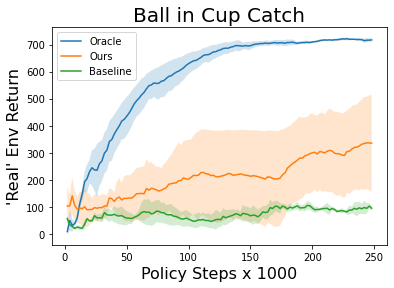

Oracle
Lengths found 499 499
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 55 55
Lengths found 124 124
Baseline
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124


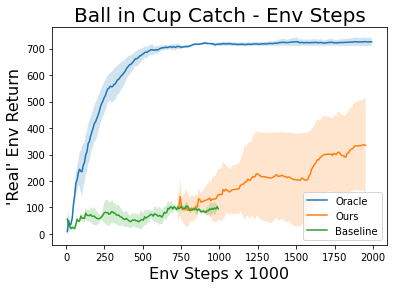

len 10
len 10
len 10

Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


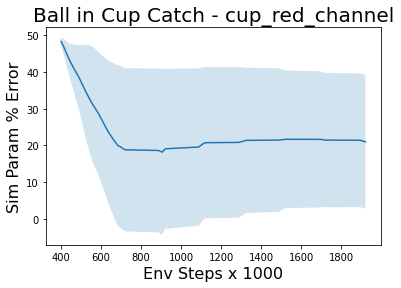


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


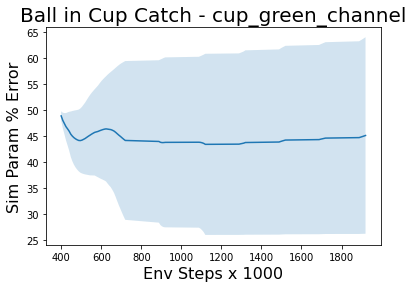


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


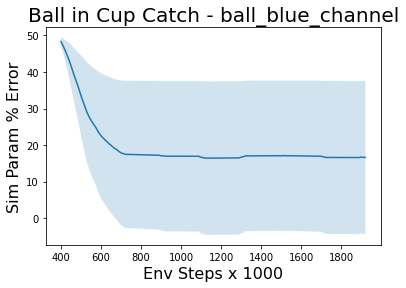


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


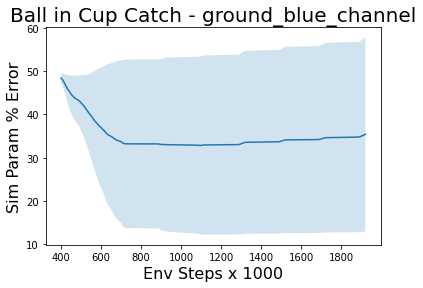


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


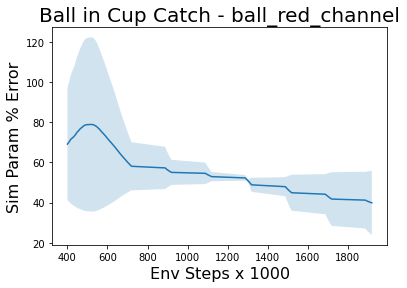


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


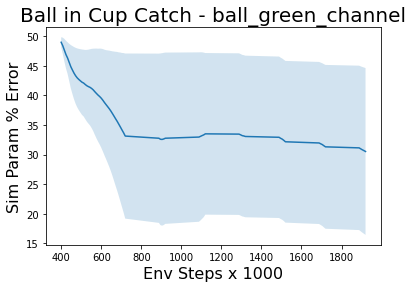


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


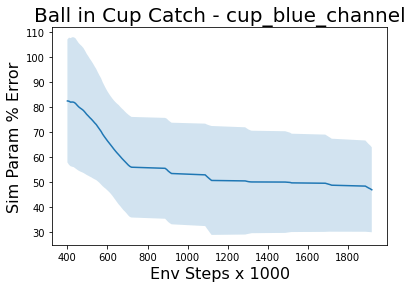


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


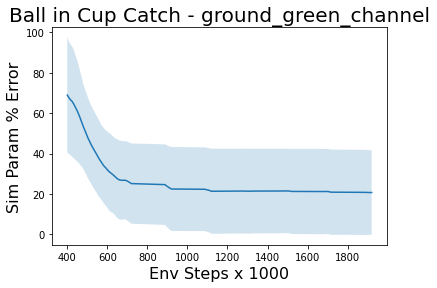


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


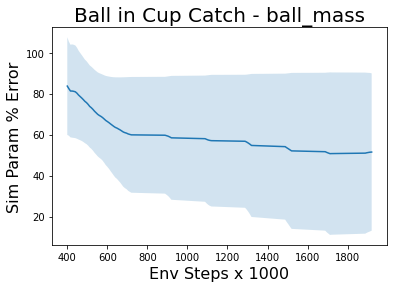


Lengths found 71 71
Lengths found 51 51
Lengths found 71 71


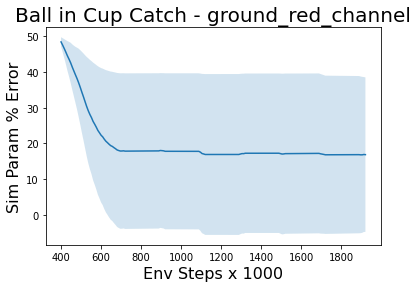

In [9]:
pretrain_steps = 180000

condition = "Ball in Cup Catch"
env_scale = .001 * 4
oracle_runs = [
    "S0602_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop",
    "S2018_dmc_ball_in_cup-catch-im84-b128-s3-curl_sac-pixel-crop",
    "2048_dmc_ball_in_cup-catch-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3120_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
    "S3124_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
    "S3128_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2059_dmc_ball_in_cup-catch-im84-b128-s0-curl_sac-pixel-crop",
    "S2032_dmc_ball_in_cup-catch-im84-b128-s1-curl_sac-pixel-crop",
    "S2036_dmc_ball_in_cup-catch-im84-b128-s2-curl_sac-pixel-crop"
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}
plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=250000, pretrain_steps=standard_pretrain_steps, filter_by_freq=True)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=500000, scale=env_scale, filter_by_freq=True)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=True)



## Walker

Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Baseline
reduced extra logging; from  413  to  249
Lengths found 249 249
reduced extra logging; from  270  to  249
Lengths found 249 249
Lengths found 249 249


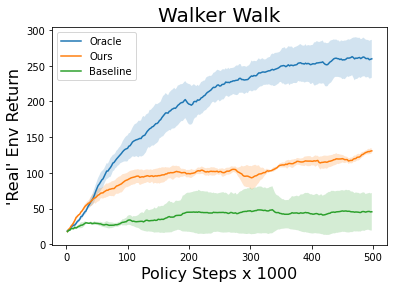

Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Baseline
reduced extra logging; from  413  to  249
Lengths found 249 249
reduced extra logging; from  270  to  249
Lengths found 249 249
Lengths found 249 249


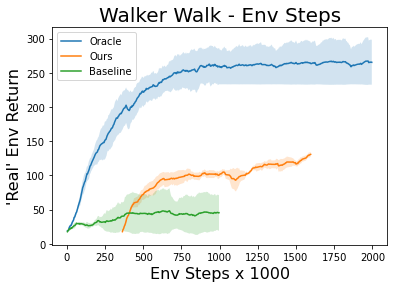

len 7
len 7
len 7

Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


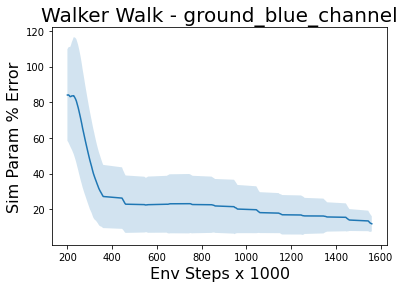


Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


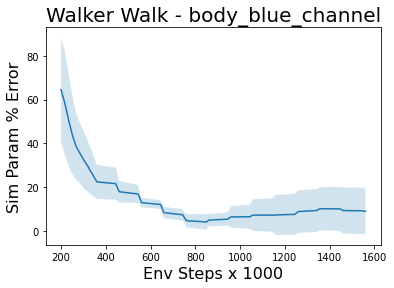


Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


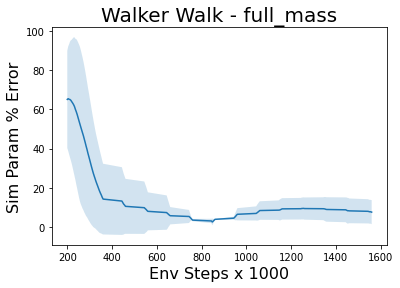


Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


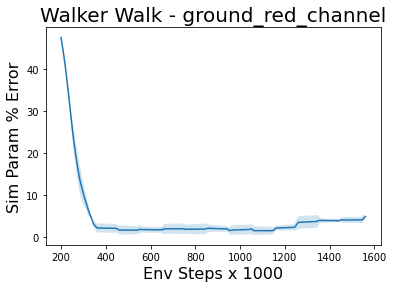


Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


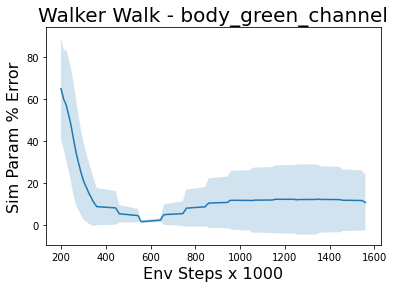


Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


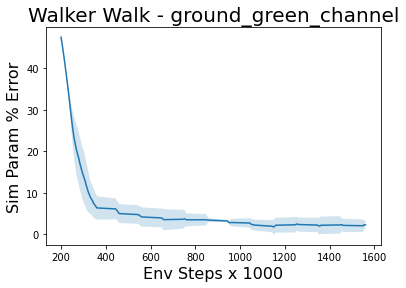


Lengths found 101 101
Lengths found 101 101
Lengths found 101 101


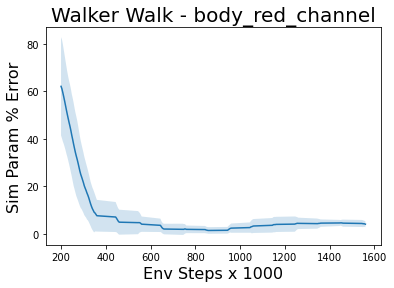

In [10]:
condition = "Walker Walk"
env_scale= .001 * 2
oracle_runs = [
    "S0600_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
    "S2014_dmc_walker-walk-im84-b128-s3-curl_sac-pixel-crop",
    "2049_dmc_walker-walk-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3121_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
    "S3125_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
    "S3129_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2060_dmc_walker-walk-im84-b128-s0-curl_sac-pixel-crop",
    "S2033_dmc_walker-walk-im84-b128-s1-curl_sac-pixel-crop",
    "S2037_dmc_walker-walk-im84-b128-s2-curl_sac-pixel-crop",
]
plot_dict = {
    "Oracle": oracle_runs,
    "Ours": ol3_runs,
    "Baseline": baseline_runs,
}

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}
plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=True)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale, filter_by_freq=True)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=True)



Oracle
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124
Baseline
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124


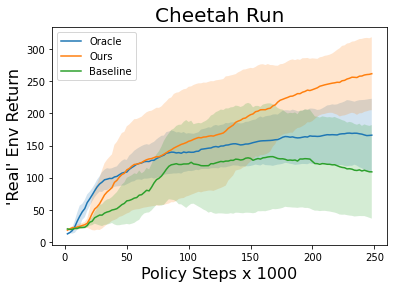

Oracle
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124
Ours
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124
Baseline
Lengths found 124 124
Lengths found 124 124
Lengths found 124 124


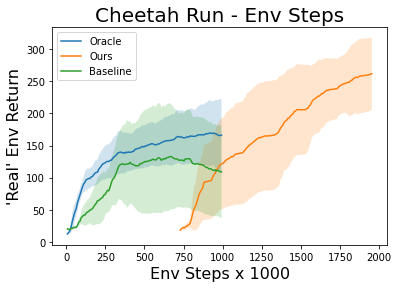

len 7
len 7
len 7

Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


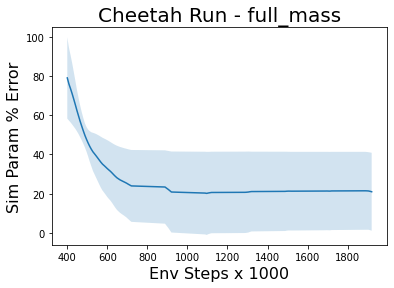


Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


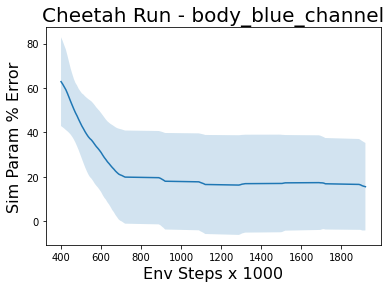


Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


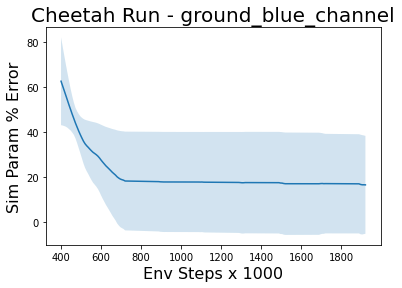


Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


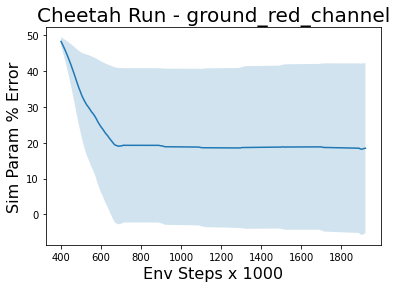


Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


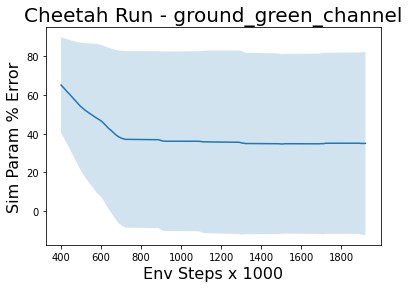


Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


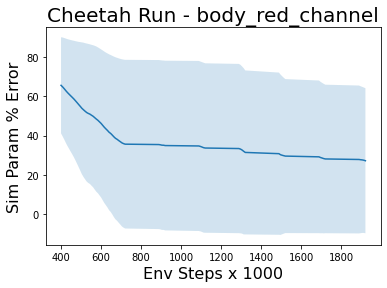


Lengths found 71 71
Lengths found 71 71
Lengths found 71 71


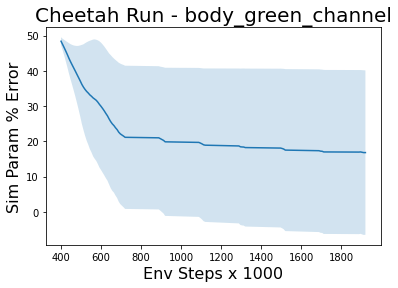

In [11]:
condition = "Cheetah Run"
env_scale = .001 * 4

oracle_runs = [
    "S2019_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
    "S2020_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop",
    "2050_dmc_cheetah-run-im84-b128-s5-curl_sac-pixel-crop",
]

ol3_runs = [
    "S3122_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
    "S3126_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
    "S3130_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S2061_dmc_cheetah-run-im84-b128-s0-curl_sac-pixel-crop",
    "S2034_dmc_cheetah-run-im84-b128-s1-curl_sac-pixel-crop",
    "S2038_dmc_cheetah-run-im84-b128-s2-curl_sac-pixel-crop"
]
plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=250000, pretrain_steps=standard_pretrain_steps, filter_by_freq=True)


plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale, filter_by_freq=True)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=True)



Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 249 249
Lengths found 249 249
Lengths found 239 239
Baseline
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249


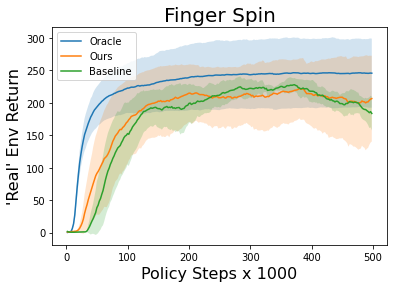

Oracle
Lengths found 499 499
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 249 249
Lengths found 249 249
Lengths found 239 239
Baseline
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249


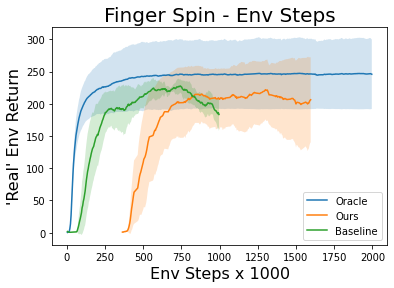

len 11
len 11
len 11

Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


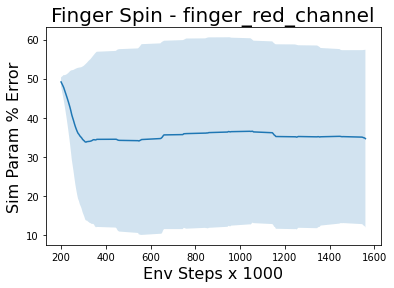


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


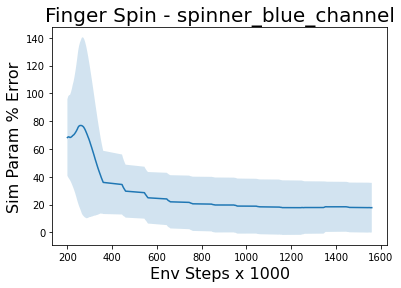


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


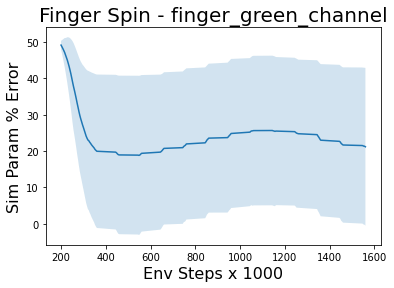


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


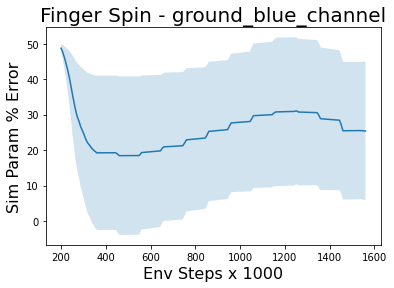


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


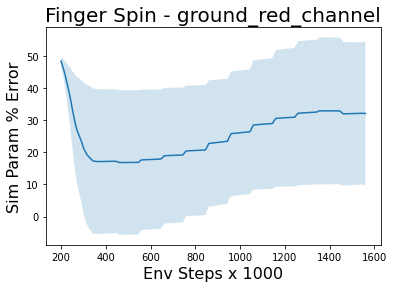


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


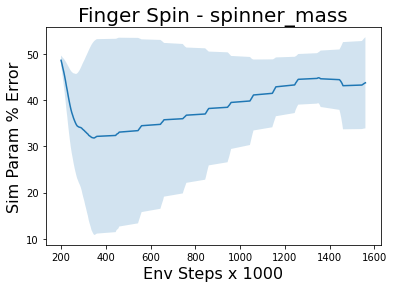


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


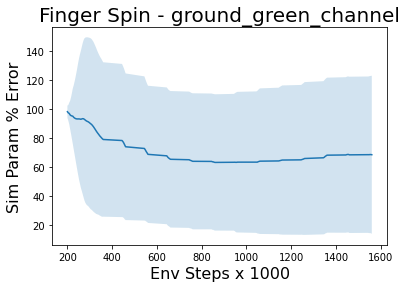


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


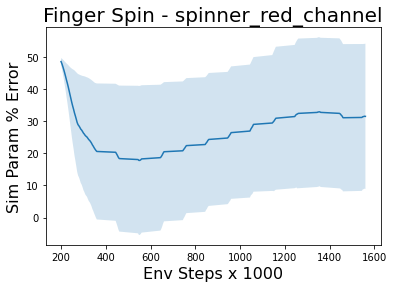


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


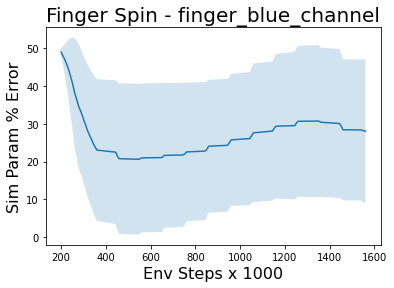


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


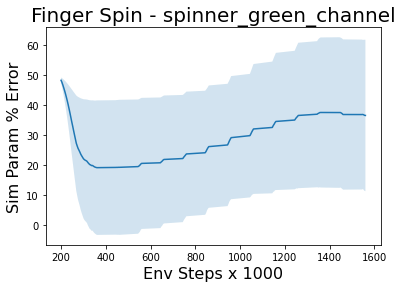


Lengths found 101 101
Lengths found 101 101
Lengths found 96 96


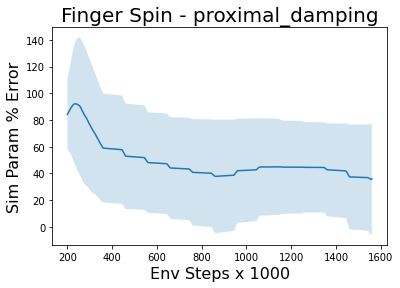

In [23]:
condition = "Finger Spin"
env_scale = .001 * 2

oracle_runs = [
    "S0603_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop",
    "S2016_dmc_finger-spin-im84-b128-s3-curl_sac-pixel-crop",
    "2051_dmc_finger-spin-im84-b128-s5-curl_sac-pixel-crop",
]
ol3_runs = [
    "S3123_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
    "S3127_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop", # UH OH!!
    "S3131_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop"
]
baseline_runs = [
    "S2062_dmc_finger-spin-im84-b128-s0-curl_sac-pixel-crop",
    "S2035_dmc_finger-spin-im84-b128-s1-curl_sac-pixel-crop",
    "S2039_dmc_finger-spin-im84-b128-s2-curl_sac-pixel-crop",
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=True)

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale, filter_by_freq=True)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=True)



Oracle
Lengths found 272 272
Lengths found 290 290
Lengths found 249 249
Ours
Lengths found 200 200
Lengths found 214 214
Lengths found 200 200
Baseline
Lengths found 87 87
Lengths found 256 256
Lengths found 269 269


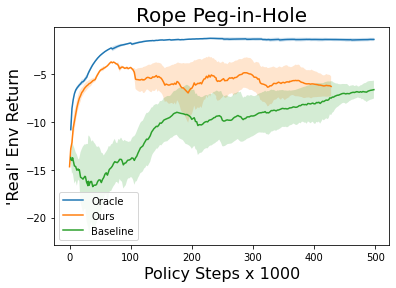

Oracle
Lengths found 272 272
Lengths found 290 290
Lengths found 249 249
Ours
reduced extra logging; from  200  to  67
Lengths found 67 67
reduced extra logging; from  214  to  71
Lengths found 71 71
reduced extra logging; from  200  to  67
Lengths found 67 67
Baseline
reduced extra logging; from  87  to  14
Lengths found 14 14
reduced extra logging; from  256  to  79
Lengths found 79 79
Lengths found 269 269


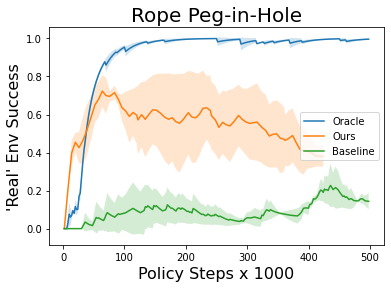

Oracle
Lengths found 272 272
Lengths found 290 290
Lengths found 249 249
Ours
Lengths found 200 200
Lengths found 214 214
Lengths found 200 200
Baseline
Lengths found 87 87
Lengths found 256 256
Lengths found 269 269


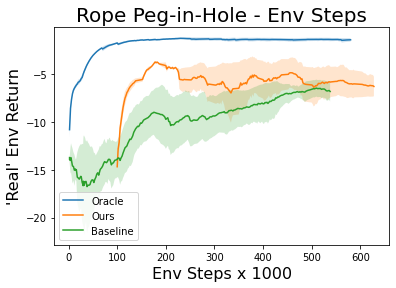

len 9
len 9
len 9

Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


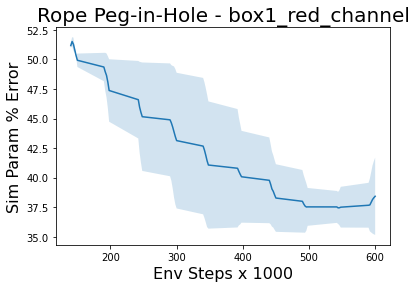


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


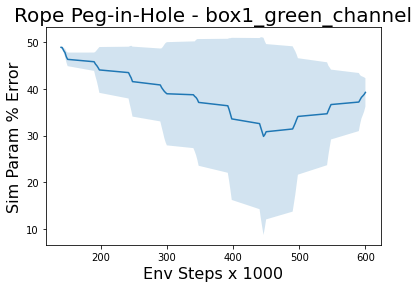


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


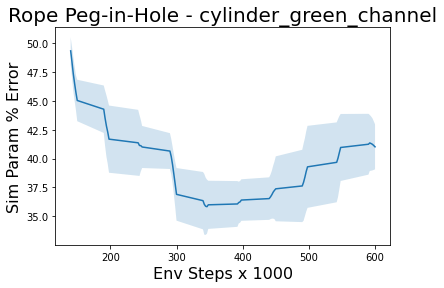


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


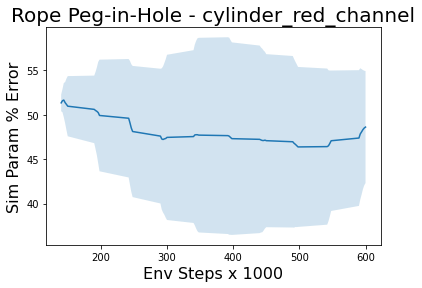


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


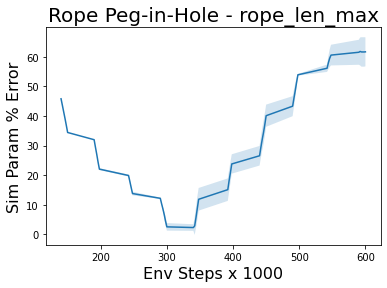


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


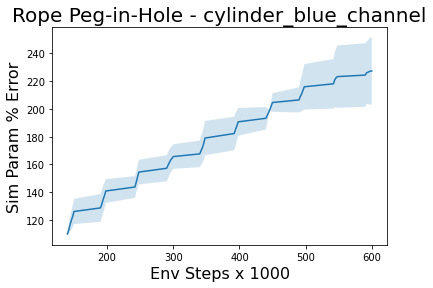


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


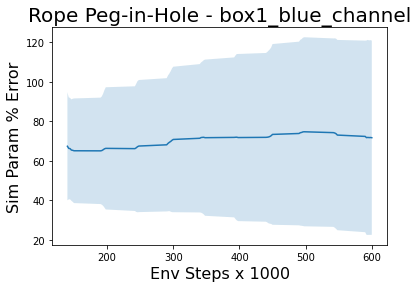


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


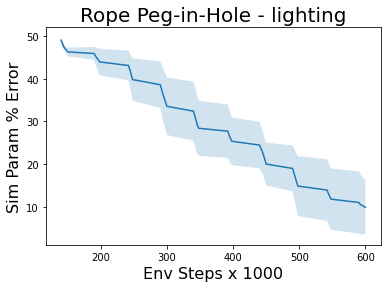


Lengths found 47 47
Lengths found 51 51
Lengths found 47 47


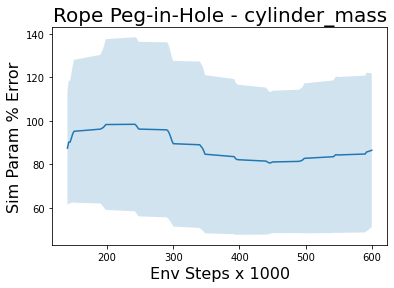

In [13]:
condition = "Rope Peg-in-Hole"
env_scale = .001

oracle_runs = [
    "S0902_kitchen-rope-im84-b128-s1-curl_sac-pixel-crop",
    "S0903_kitchen-rope-im84-b128-s2-curl_sac-pixel-crop",
    "S0904_kitchen-rope-im84-b128-s0-curl_sac-pixel-crop",
]
ol3_runs = [
    "S01148_kitchen-rope-im84-b128-s1-curl_sac-pixel-crop",
    "S01154_kitchen-rope-im84-b128-s2-curl_sac-pixel-crop",
    "S01148_kitchen-rope-im84-b128-s1-curl_sac-pixel-crop",
]
baseline_runs = [
    "S0881_kitchen-rope-im84-b128-s1-curl_sac-pixel-crop", 
    "S0877_kitchen-rope-im84-b128-s0-curl_sac-pixel-crop",
    "S0869_kitchen-rope-im84-b128-s2-curl_sac-pixel-crop"
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000, pretrain_steps=shorter_pretrain_steps, filter_by_freq=False)
plot_final_returns(plot_dict, policy_label_x, success_label_y, condition, test_success_series_name, clip_to=500000, filter_by_freq=True)

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale, filter_by_freq=False)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=False)



Oracle
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 203 203
Lengths found 250 250
Lengths found 232 232
Baseline
Lengths found 300 300
Lengths found 279 279
Lengths found 293 293


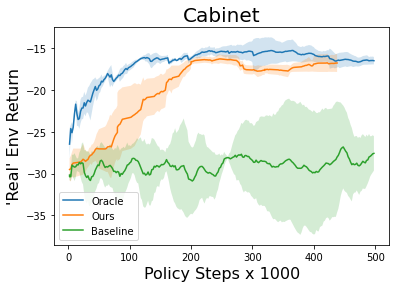

Oracle
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 203 203
Lengths found 250 250
Lengths found 232 232
Baseline
Lengths found 300 300
Lengths found 279 279
Lengths found 293 293


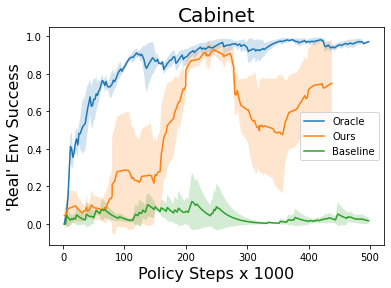

Oracle
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Ours - Pretrained
Lengths found 249 249
Lengths found 222 222
Lengths found 199 199


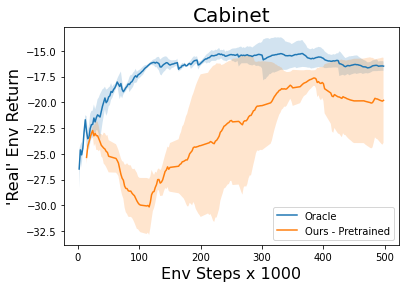

Oracle
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Ours - Pretrained
Lengths found 249 249
Lengths found 222 222
Lengths found 199 199


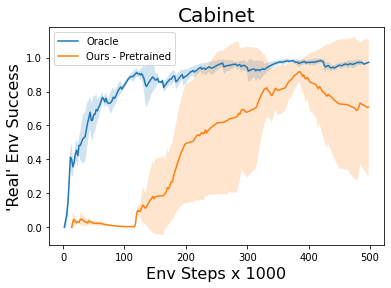

Oracle
Lengths found 249 249
Lengths found 249 249
Lengths found 249 249
Ours
Lengths found 203 203
Lengths found 250 250
Lengths found 232 232
Baseline
Lengths found 300 300
Lengths found 279 279
Lengths found 293 293


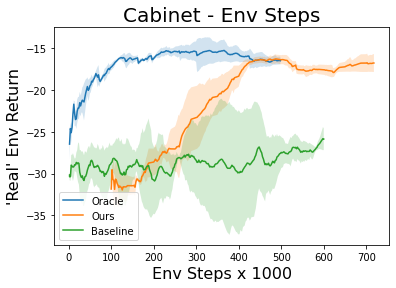

len 9
len 9
len 9

reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


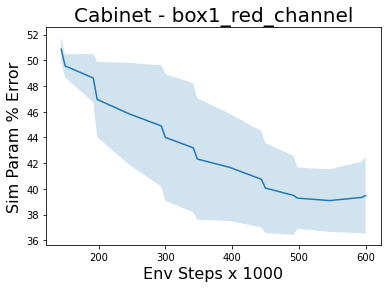


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


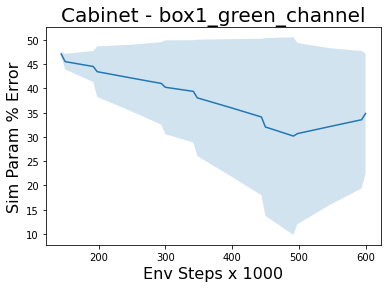


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


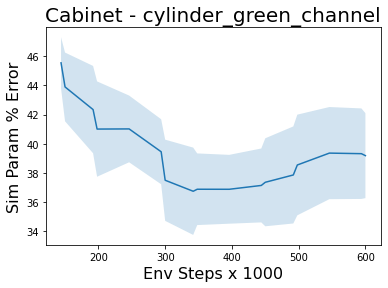


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


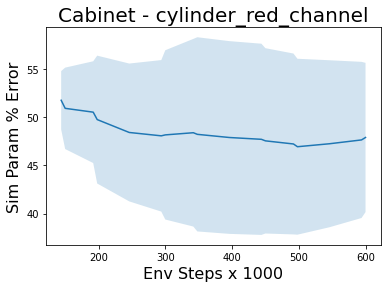


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


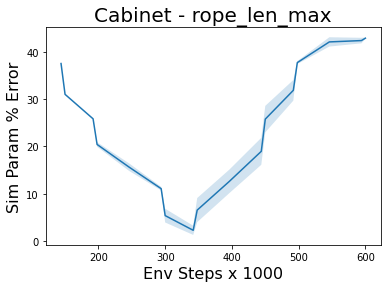


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


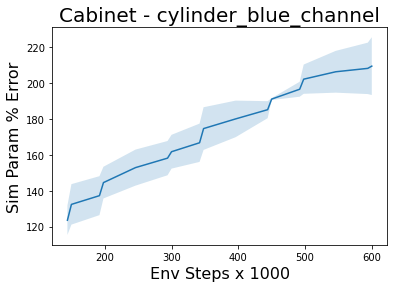


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


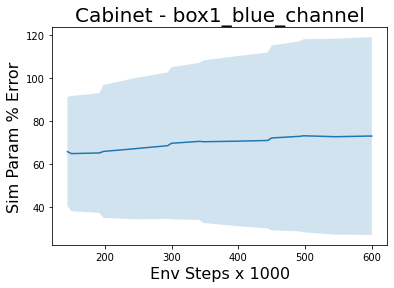


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


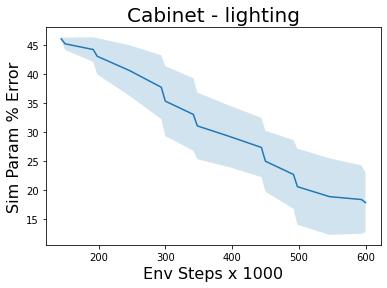


reduced extra logging; from  47  to  15
Lengths found 15 15
reduced extra logging; from  51  to  17
Lengths found 17 17
reduced extra logging; from  47  to  15
Lengths found 15 15


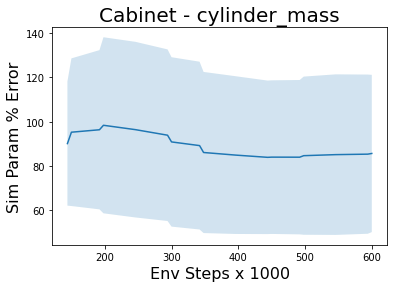

In [14]:
condition = "Cabinet"

oracle_runs = [
    "S0938_kitchen-real_c-im84-b128-s0-curl_sac-pixel-crop",
    "S0939_kitchen-real_c-im84-b128-s1-curl_sac-pixel-crop",
    "S0940_kitchen-real_c-im84-b128-s2-curl_sac-pixel-crop",
]
ol3_runs_Y = [
    "S1156_kitchen-real_c-im84-b128-s0-curl_sac-pixel-crop",
    "S1147_kitchen-real_c-im84-b128-s1-curl_sac-pixel-crop",
    "S1157_kitchen-real_c-im84-b128-s2-curl_sac-pixel-crop",
]
ol3_runs_O = [
    "S1153_kitchen-real_c-im84-b128-s0-curl_sac-pixel-crop",
    "S1158_kitchen-real_c-im84-b128-s1-curl_sac-pixel-crop",
    "S1159_kitchen-real_c-im84-b128-s2-curl_sac-pixel-crop",
]
baseline_runs = [
    "S0878_kitchen-real_c-im84-b128-s0-curl_sac-pixel-crop",
    "S0875_kitchen-real_c-im84-b128-s1-curl_sac-pixel-crop",
    "S0879_kitchen-real_c-im84-b128-s2-curl_sac-pixel-crop",
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs_Y, True),
    "Baseline": (baseline_runs, False),
}
plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=False)
plot_final_returns(plot_dict, policy_label_x, success_label_y, condition, test_success_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=False)

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours - Pretrained": (ol3_runs_O, False),
}
plot_final_returns(plot_dict, env_label_x, return_label_y, condition, test_return_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=False)
plot_final_returns(plot_dict, env_label_x, success_label_y, condition, test_success_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=False)

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs_Y, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale, filter_by_freq=False)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=True)



Oracle
Lengths found 54 54
Lengths found 62 62
Lengths found 62 62
Ours
Lengths found 62 62
Lengths found 9 9
Lengths found 0 0
Baseline
Lengths found 59 59
Lengths found 62 62
Lengths found 62 62


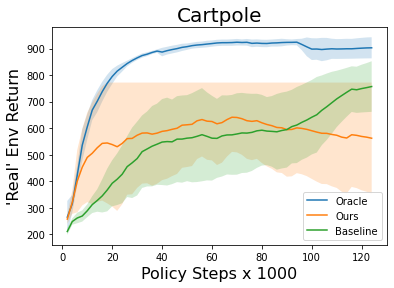

Ours
Lengths found 62 62
Lengths found 9 9
Lengths found 0 0


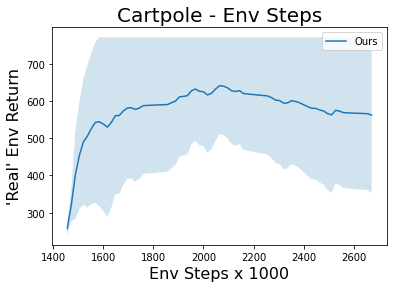

len 8
len 8
len 8

Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


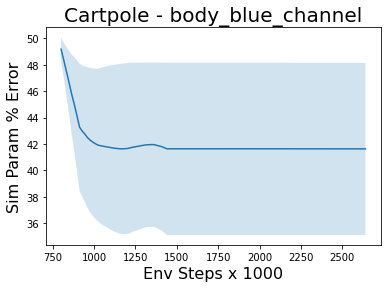


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


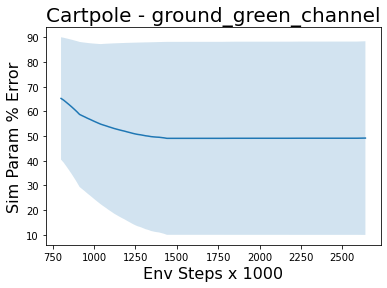


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


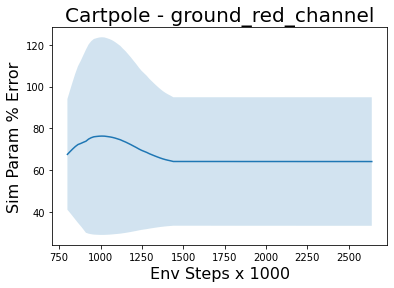


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


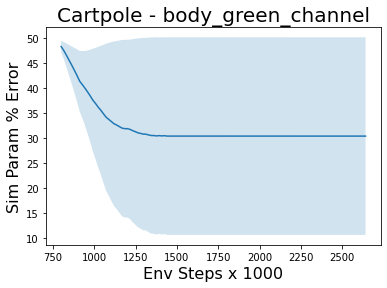


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


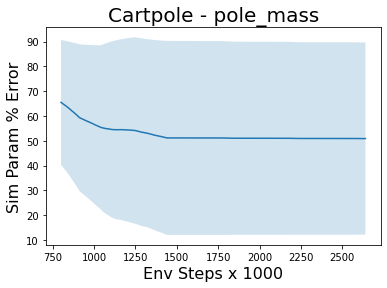


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


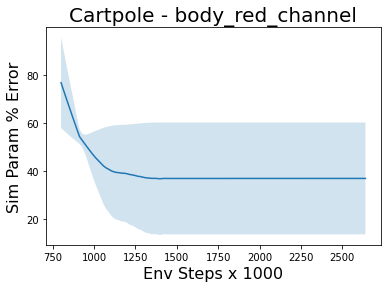


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


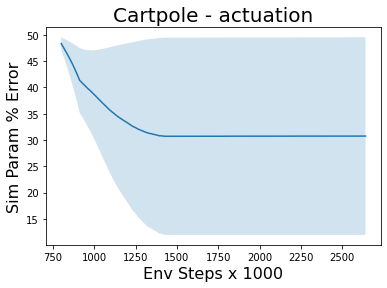


Lengths found 56 56
Lengths found 41 41
Lengths found 8 8


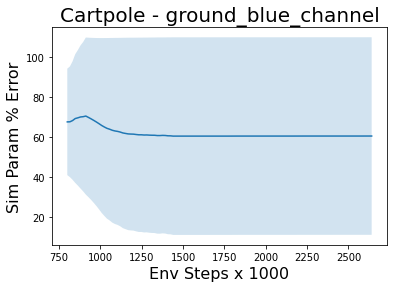

In [28]:
condition = "Cartpole"
env_scale = .001 * 8



oracle_runs = [
    "S2065_dmc_cartpole-balance-im84-b128-s3-curl_sac-pixel-crop",
    "S2066_dmc_cartpole-balance-im84-b128-s4-curl_sac-pixel-crop",
    "S2067_dmc_cartpole-balance-im84-b128-s5-curl_sac-pixel-crop",
]

ol3_runs = [
    "S3135_dmc_cartpole-balance-im84-b128-s1-curl_sac-pixel-crop",
    "S3136_dmc_cartpole-balance-im84-b128-s2-curl_sac-pixel-crop",
    "S3134_dmc_cartpole-balance-im84-b128-s0-curl_sac-pixel-crop"
]
baseline_runs = [
    "S2068_dmc_cartpole-balance-im84-b128-s0-curl_sac-pixel-crop",
    "S2069_dmc_cartpole-balance-im84-b128-s1-curl_sac-pixel-crop",
    "S2070_dmc_cartpole-balance-im84-b128-s2-curl_sac-pixel-crop",
]

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, True),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, policy_label_x, return_label_y, condition, test_return_series_name, clip_to=500000, pretrain_steps=standard_pretrain_steps, filter_by_freq=True)

plot_dict = {
    "Oracle": (oracle_runs, False),
    "Ours": (ol3_runs, False),
    "Baseline": (baseline_runs, False),
}

plot_final_returns(plot_dict, env_label_x, return_label_y, condition + " - Env Steps", test_return_series_name, clip_to=1000000, scale=env_scale, filter_by_freq=True)
plot_spe(ol3_runs, False, env_label_x, spe_label_y, condition, spe_series_name, clip_to=None, scale=env_scale, filter_by_freq=True)

print("=" * 100)


oracle_runs = [
    "S2065_dmc_cartpole-balance-im84-b128-s3-curl_sac-pixel-crop",
    "S2066_dmc_cartpole-balance-im84-b128-s4-curl_sac-pixel-crop",
    "S2067_dmc_cartpole-balance-im84-b128-s5-curl_sac-pixel-crop",
]

ol3_runs = [
    "S3135_dmc_cartpole-balance-im84-b128-s1-curl_sac-pixel-crop",
    "S3136_dmc_cartpole-balance-im84-b128-s2-curl_sac-pixel-crop",
    "S3134_dmc_cartpole-balance-im84-b128-s0-curl_sac-pixel-crop"
]
